<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [6]:
from __future__ import division, print_function

import itertools
import collections
import pprint
import datetime as dt

# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('/home/truename/Documents/capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [1]:
def old_prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    csvfiles = sorted([os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path_to_csv_files)
    for f in files if f.endswith('.csv')])
    dict_sites={}
    site_id=1
    user_id=1
    cols = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
    df=pd.DataFrame(columns=cols)
    for f in csvfiles:
        fcsv = pd.read_csv(f,',',header=0)
        sess_id = 1
        numRows = fcsv.shape[0]//window_size + (1 if fcsv.shape[0]%window_size > 0 else 0)
        df_file = pd.DataFrame(index=range(numRows), columns=cols)
        i = 0
        sess_id = 1
        row = 0
        time_min = datetime.strptime("2049-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
        time_max = datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
        unq_sites = 0
        unq_sites_d = []
        start_hour = 0
        day = 0
        while (i < fcsv.shape[0]):
            df_file.iloc[row,(sess_id-1)] = fcsv.loc[i,"site"]
            time1 = datetime.strptime(fcsv.loc[i,"timestamp"], "%Y-%m-%d %H:%M:%S")
            if sess_id > 1:
                df_file.ix[row,'time_diff'+str(sess_id-1)] = int((time1-time0).total_seconds()) if time1 > time0 else 0
            time0 = time1
            if time1 > time_max:
                time_max = time1
            if time1 < time_min:
                time_min = time1
            if fcsv.loc[i,"site"] not in unq_sites_d:
                unq_sites_d.append(fcsv.loc[i,"site"])
                unq_sites += 1
            if fcsv.loc[i,"site"] in dict_sites:
                dict_sites[fcsv.loc[i,"site"]] = (dict_sites[fcsv.loc[i,"site"]][0],dict_sites[fcsv.loc[i,"site"]][1]+1)
            else:
                dict_sites[fcsv.loc[i,"site"]] = (site_id,1)
                site_id+=1
            if (sess_id%session_length == 0) | ((i==fcsv.shape[0]-1) & (sess_id >= window_size)):
                if fcsv.shape[0]-1 >= (row+1)*window_size:
                    i = (row+1)*window_size
                else:
                    i -= (session_length - window_size) -1
                sess_id = 1
                df_file.ix[row,'session_timespan'] = int((time_max-time_min).total_seconds())if time_max > time_min else 0
                df_file.ix[row,'#unique_sites'] = unq_sites
                df_file.ix[row,'start_hour'] = time_min.hour
                df_file.ix[row,'day_of_week'] = time_min.weekday()
                
                time_min = datetime.strptime("2049-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                time_max = datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                unq_sites = 0
                unq_sites_d = []
                start_hour = 0
                day = 0
                row += 1
            else:
                i += 1
                sess_id += 1
        if sess_id > 1:
            df_file.ix[row,'time_diff'+str(sess_id-1)] = int((time1-time0).total_seconds()) if time1 > time0 else 0
        df_file.ix[row,'session_timespan'] = int((time_max-time_min).total_seconds()) if time_max > time_min else 0
        df_file.ix[row,'#unique_sites'] = unq_sites
        df_file.ix[row,'start_hour'] = time_min.hour
        df_file.ix[row,'day_of_week'] = time_min.weekday()
        df_file['target'] = user_id
        df = df.append(df_file, ignore_index = True)
        user_id+=1
    dict_sites=sorted(dict_sites.items(), key=lambda x: (-x[1][1],x[0]))
    site_id=1
    d={}
    for i in dict_sites:
        d[i[0]]=(site_id,i[1][1])
        site_id+=1
    df.fillna(0, inplace=True)
    for i in d:
        df.replace(i, d[i][0], inplace=True)
    return df.ix[:,feature_names]

In [4]:
def split_sessions(path_to_csv_files, session_length=10, window_size=None):
    if window_size is None:
        window_size = session_length
        
    # формирование сессий
    raw_sessions = []
    users = []
    for fpath in glob(os.path.join(path_to_csv_files, '*')):
        fname = os.path.basename(fpath)
        uid = int(fname[4:8])
        
        with open(fpath, 'r') as f:
            next(f)  # skip first line
            
            for i, line in enumerate(f):               
                if not users or users[-1] != uid or len(raw_sessions[-1]) >= window_size:
                    raw_sessions.append([])
                    users.append(uid)
                    
                for session in reversed(raw_sessions):
                    if len(session) >= session_length:
                        break
                        
                    session.append(line.strip('\n'))
        
        for session in reversed(raw_sessions):
            if len(session) >= session_length:
                break

            session += [''] * (session_length - len(session))
    
    return raw_sessions, users

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=None):   
    with open(site_freq_path, 'rb') as f:
        freq = pickle.load(f)
    
    def register_site(site):
        return freq[site][0]
    
    # формирование сессий
    raw_sessions, users = split_sessions(path_to_csv_files, session_length, window_size)
       
    sessions = []
    for uid, raw_session in itertools.izip(users, raw_sessions):
        session = []
        sessions.append(session)
        
        min_dt = None
        max_dt = None
        prev_dt = None
        time_diffs = []
        for line in raw_session:
            if not line:
                session.append(0)
                time_diffs.append(0)
                continue
                
            dt_, site = line.split(',')
            dt_ = dt.datetime.strptime(dt_, '%Y-%m-%d %H:%M:%S')
            site_id = register_site(site)
            
            min_dt = min(min_dt or dt_, dt_)
            max_dt = max(max_dt or dt_, dt_)
            session.append(site_id)
            
            if prev_dt is not None:
                time_diffs.append(int((dt_ - prev_dt).total_seconds()))
            prev_dt = dt_
          
        num_uniq = len(set(session) - {0})
        session += time_diffs
        session.append(int((max_dt - min_dt).total_seconds()))
        session.append(num_uniq)
        session.append(min_dt.hour)
        session.append(min_dt.weekday())
        session.append(uid)
        
    return pd.DataFrame(sessions, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,1,2,1,2,1,1,5,10,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
1,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
2,4,2,2,11,2,1,8,5,9,7,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
3,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
4,4,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2.27 s, sys: 4 ms, total: 2.28 s
Wall time: 2.28 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,60,60,267,69,160,69,39,39,256,67,2,1,61,1,0,222,1184,1574,4698,7743,7,9,4,50
1,67,581,15,72,15,15,15,2373,2300,2543,5,7,1,3,1,4,12,0,1,34,7,11,4,50
2,37,23,23,67,30,3,10,33,6,52,0,1,7,131,2,1,2,3,37,184,9,11,4,50
3,52,9,85,80,9,4,33,9,37,23,17,103,240,97,7,186,517,538,0,1705,8,11,4,50
4,23,9,9,9,37,23,9,9,4,9,61,601,601,485,1,114,600,365,235,3063,4,12,4,50


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 23.7 s, sys: 188 ms, total: 23.8 s
Wall time: 24 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features_10users = train_data_10users.ix[:, ['session_timespan','#unique_sites','start_hour','day_of_week']].values
new_features_150users = train_data_150users.ix[:, ['session_timespan','#unique_sites','start_hour','day_of_week']].values

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

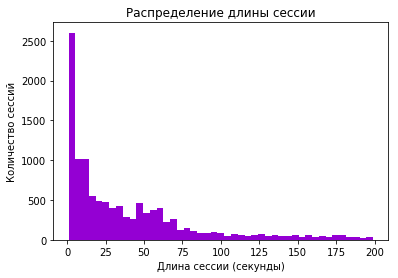

In [13]:
x = train_data_10users['session_timespan']
x = x[(x>0) & (x<200)].values
plt.hist(pd.Series(x), bins='auto', facecolor='darkviolet')
plt.xlabel(u'Длина сессии (секунды)')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение длины сессии')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

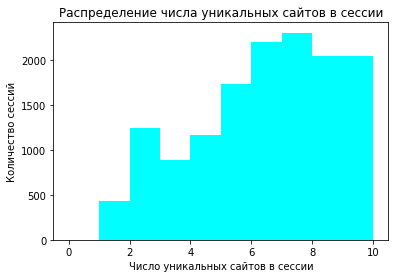

In [14]:
plt.hist(pd.Series(train_data_10users['#unique_sites'].values), facecolor='aqua')
plt.xlabel(u'Число уникальных сайтов в сессии')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение числа уникальных сайтов в сессии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

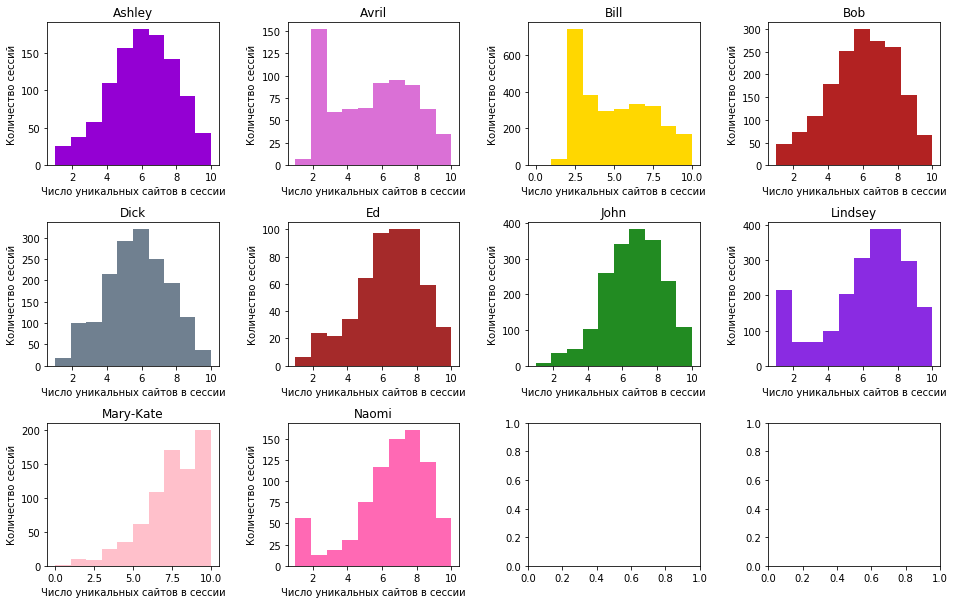

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace = 0.4,wspace = 0.4)
r,c=0,0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    axes[r,c].hist(pd.Series(sub_df['#unique_sites'].values), facecolor=color_dic[user], label=user)
    axes[r,c].set_xlabel(u'Число уникальных сайтов в сессии')
    axes[r,c].set_ylabel(u'Количество сессий')
    axes[r,c].set_title(user)
    r += 1 if (r < 2) & (c == 3) else 0
    c = (c + 1) if c < 3 else 0

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

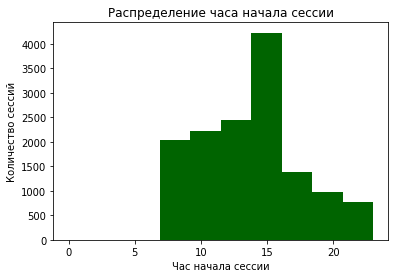

In [16]:
plt.hist(pd.Series(train_data_10users['start_hour'].values), facecolor='darkgreen')
plt.xlabel(u'Час начала сессии')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение часа начала сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

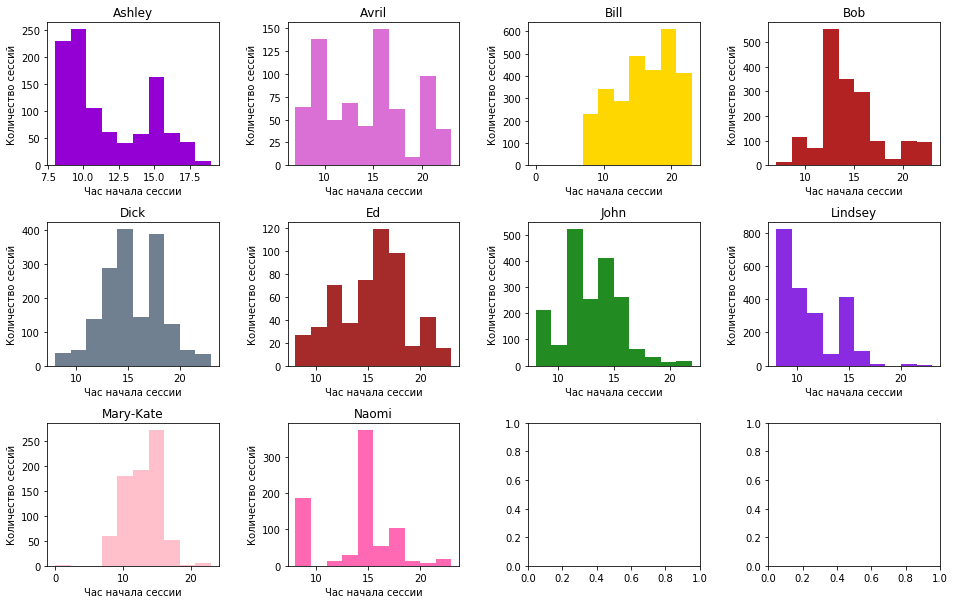

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace = 0.4,wspace = 0.4)
r,c=0,0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    axes[r,c].hist(pd.Series(sub_df['start_hour'].values), facecolor=color_dic[user], label=user)
    axes[r,c].set_xlabel(u'Час начала сессии')
    axes[r,c].set_ylabel(u'Количество сессий')
    axes[r,c].set_title(user)
    r += 1 if (r < 2) & (c == 3) else 0
    c = (c + 1) if c < 3 else 0

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

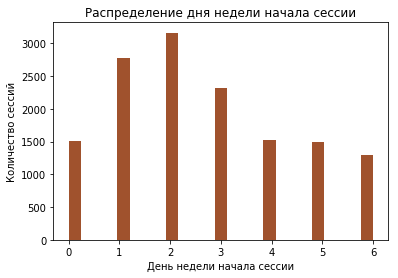

In [18]:
plt.hist(pd.Series(train_data_10users['day_of_week'].values), facecolor='sienna', bins='auto')
plt.xlabel(u'День недели начала сессии')
plt.ylabel(u'Количество сессий')
plt.title(u'Распределение дня недели начала сессии')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

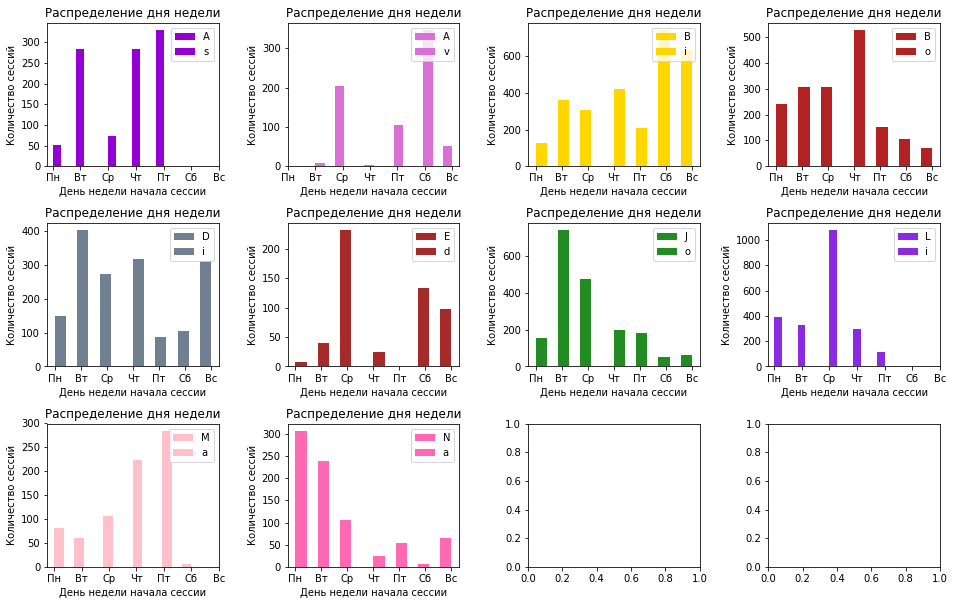

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace = 0.4,wspace = 0.4)
r,c=0,0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    axes[r,c].hist(pd.Series(sub_df['day_of_week'].values), facecolor=color_dic[user], label=user, bins=14)
    axes[r,c].set_xlabel(u'День недели начала сессии')
    axes[r,c].set_ylabel(u'Количество сессий')
    axes[r,c].set_xticks(range(7))
    axes[r,c].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[r,c].set_title(u'Распределение дня недели')
    axes[r,c].legend(user,loc="upper right")
    r += 1 if (r < 2) & (c == 3) else 0
    c = (c + 1) if c < 3 else 0

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Ashley**
Сидит в интернете в рабочие дни, в основном во вторник, четверг и пятницу.
В основном утром (7:00-10:00) и после обеда (15:00).
Количество различных сайтов в сессии из 10 распределно нормально.

**Avril**
Сидит в интернете всю неделю, в основном в среду и субботу.
В основном утром (9:00), после обеда (15:00) и вечером (20:00).
Обычно ходит на 2 разных сайта, но бывает, что проверяет и больше.

**Bill**
Сидит в интернете всю неделю, по большей части в выходные.
Начинает с 9:00 и до 21:00.
Обычно ходит на пару сайтов.

**Bob**
Сидит в интернете всю неделю, с понедельника до среды "зависает" в интернете все больше, далее активность в интернете спадает.
В основном в обед с 12:00 до 15:00.
Количество различных сайтов в сессии из 10 распределно нормально.

**Dick**
Сидит в интернете всю неделю, спады активности только в понедельник, пятницу и субботу (видимо любит "отрываться" на выходных вдали от интернета =) ).
Начинает скучать в интернете в середине рабочего дня.
Количество различных сайтов в сессии из 10 распределно нормально.

**Ed**
Сидит в интернете всю неделю, кроме пятницы, по большей части в среду.
Начинает в основном после 15:00.
Обычно ходит на разные сайтов.

**John**
Сидит в интернете всю неделю, по большей части во вторник.
Начинает с обеда и всю вторую половину рабочего дня.
Обычно ходит на разные сайтов.

**Lindsey**
Сидит в интернете в рабочие дни, в основном в среду.
В основном утром (9:00-10:00) и после обеда (15:00).
Обычно посещает разные сайты (из 10 сайтов в сессии 6-9 разных)

**Mary-Kate**
Сидит в интернете в рабочие дни, с постепенным увеличением количества сессий к концу недели.
Похоже, что делает это на работе, т.к. сессии зафиксированы с 9:00 до 19:00.
Обычно ходит по разным сайтам.

**Naomi**
Сидит в интернете всю неделю, в основном в начале недели (понедельник, вторник).
В основном утром (9:00) и после обеда (15:00).
Обычно посещает разные сайты (из 10 сайтов в сессии 6-9 разных)

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [20]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as pkl_file:
    data1 = pickle.load(pkl_file)
dict_sites=sorted(data1.items(), key=lambda x: x[1][1], reverse=True)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
top10_freqs = [i[1][1] for i in dict_sites[:10]]
top10_sites = [i[0] for i in dict_sites[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [22]:
df = {'x': top10_sites, 'y': top10_freqs}
df = pd.DataFrame(data=df)

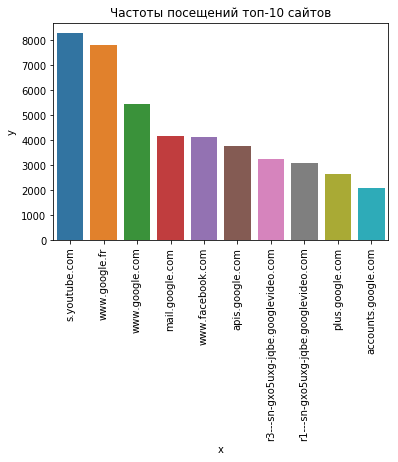

In [25]:
bp = sns.barplot(x='x',y='y',data=df)
loc, labels = plt.xticks()
bp.set_xticklabels(labels, rotation=90)
bp.set_title(u'Частоты посещений топ-10 сайтов')

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [31]:
print('Медианная продолжительность сессии %d секунд'%train_data_10users['session_timespan'].median())

Медианная продолжительность сессии 37 секунд


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [33]:
print(u'Медианный день недели, в который началась сессия - %s'%[u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'][int(train_data_10users['day_of_week'].median())])

Медианный день недели, в который началась сессия - Ср


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [34]:
print('Медианный час начала сессии %d секунд'%train_data_150users['start_hour'].median())

Медианный час начала сессии 13 секунд


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [35]:
print('Медианное значение числа уникальных сайтов = %d'%train_data_150users['#unique_sites'].median())

Медианное значение числа уникальных сайтов = 7


## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [75]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    csvfiles = sorted([os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path_to_csv_files)
    for f in files if f.endswith('.csv')])
    dict_sites={}
    site_id=1
    user_id=1
    cols = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week',
                 'google','yandex','jobseekers','facebook',
                 'target']
    df=pd.DataFrame(columns=cols)
    for f in csvfiles:
        fcsv = pd.read_csv(f,',',header=0)
        sess_id = 1
        numRows = fcsv.shape[0]//window_size + (1 if fcsv.shape[0]%window_size > 0 else 0)
        df_file = pd.DataFrame(index=range(numRows), columns=cols)
        i = 0
        sess_id = 1
        row = 0
        time_min = datetime.strptime("2049-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
        time_max = datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
        unq_sites = 0
        unq_sites_d = []
        start_hour = 0
        day = 0
        ggl = 0
        ydx = 0
        jbs = 0
        fb = 0
        while (i < fcsv.shape[0]):
            df_file.iloc[row,(sess_id-1)] = fcsv.loc[i,"site"]
            ggl += 1 if 'google' in fcsv.loc[i,"site"] else 0
            ydx += 1 if 'yandex' in fcsv.loc[i,"site"] else 0
            jbs += 1 if 'job' in fcsv.loc[i,"site"] else 0
            fb  += 1 if 'facebook' in fcsv.loc[i,"site"] else 0
            time1 = datetime.strptime(fcsv.loc[i,"timestamp"], "%Y-%m-%d %H:%M:%S")
            if sess_id > 1:
                df_file.ix[row,'time_diff'+str(sess_id-1)] = int((time1-time0).total_seconds()) if time1 > time0 else 0
            time0 = time1
            if time1 > time_max:
                time_max = time1
            if time1 < time_min:
                time_min = time1
            if fcsv.loc[i,"site"] not in unq_sites_d:
                unq_sites_d.append(fcsv.loc[i,"site"])
                unq_sites += 1
            if fcsv.loc[i,"site"] in dict_sites:
                dict_sites[fcsv.loc[i,"site"]] = (dict_sites[fcsv.loc[i,"site"]][0],dict_sites[fcsv.loc[i,"site"]][1]+1)
            else:
                dict_sites[fcsv.loc[i,"site"]] = (site_id,1)
                site_id+=1
            if (sess_id%session_length == 0) | ((i==fcsv.shape[0]-1) & (sess_id >= window_size)):
                if fcsv.shape[0]-1 >= (row+1)*window_size:
                    i = (row+1)*window_size
                else:
                    i -= (session_length - window_size) -1
                sess_id = 1
                df_file.ix[row,'session_timespan'] = int((time_max-time_min).total_seconds())if time_max > time_min else 0
                df_file.ix[row,'#unique_sites'] = unq_sites
                df_file.ix[row,'start_hour'] = time_min.hour
                df_file.ix[row,'day_of_week'] = time_min.weekday()
                df_file.ix[row,'google'] = ggl
                df_file.ix[row,'yeandex'] = ydx
                df_file.ix[row,'jobseekers'] = jbs
                df_file.ix[row,'facebook'] = fb
                
                time_min = datetime.strptime("2049-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                time_max = datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                unq_sites = 0
                unq_sites_d = []
                start_hour = 0
                day = 0
                ggl = 0
                ydx = 0
                jbs = 0
                fb = 0
                row += 1
            else:
                i += 1
                sess_id += 1
        if sess_id > 1:
            df_file.ix[row,'time_diff'+str(sess_id-1)] = int((time1-time0).total_seconds()) if time1 > time0 else 0
        df_file.ix[row,'session_timespan'] = int((time_max-time_min).total_seconds()) if time_max > time_min else 0
        df_file.ix[row,'#unique_sites'] = unq_sites
        df_file.ix[row,'start_hour'] = time_min.hour
        df_file.ix[row,'day_of_week'] = time_min.weekday()
        df_file.ix[row,'google'] = ggl
        df_file.ix[row,'yeandex'] = ydx
        df_file.ix[row,'jobseekers'] = jbs
        df_file.ix[row,'facebook'] = fb
        df_file['target'] = user_id
        df = df.append(df_file, ignore_index = True)
        user_id+=1
    dict_sites=sorted(dict_sites.items(), key=lambda x: (-x[1][1],x[0]))
    site_id=1
    d={}
    for i in dict_sites:
        d[i[0]]=(site_id,i[1][1])
        site_id+=1
    df.fillna(0, inplace=True)
    for i in d:
        df.replace(i, d[i][0], inplace=True)
    return df.ix[:,feature_names]

In [76]:
all_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', \
                 'google','yandex','jobseekers', 'facebook', \
                 'target']

In [77]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), \
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), \
                                           feature_names=all_feature_names, \
                                           session_length=10, window_size=10)

CPU times: user 7min 1s, sys: 264 ms, total: 7min 1s
Wall time: 7min 1s


In [78]:
new_features_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,google,yandex,jobseekers,facebook,target
0,192,577,134,3,134,134,3,134,203,134,10,0,...,0,1,0,33,5,8,4,2,0,0,0.0,1.0
1,425,193,687,254,134,31,394,3841,218,55,1,0,...,3,3,8,284,10,8,4,1,0,0,0.0,1.0
2,55,3,55,55,5,293,425,340,908,55,0,14,...,1,0,0,258,7,8,4,1,0,0,1.0,1.0
3,473,4015,473,55,55,55,55,980,201,123,2,1,...,0,0,0,30,6,8,4,0,0,0,0.0,1.0
4,348,55,5,3837,258,212,3937,2157,676,2157,1,0,...,1,1,0,6,9,8,4,0,0,0,1.0,1.0
5,227,676,212,212,55,55,128,174,3891,3657,0,0,...,844,184,4,1098,8,8,4,0,0,0,0.0,1.0
6,350,577,134,3,134,31,134,394,192,134,347099,0,...,11,1,0,347114,7,8,4,2,0,0,0.0,1.0
7,262,4007,1696,394,55,3,55,3,201,123,2,5,...,0,1,0,28,8,9,1,2,0,0,0.0,1.0
8,55,340,106,203,1280,515,55,813,106,5,1,0,...,0,0,0,2,8,9,1,0,0,0,1.0,1.0
9,1035,350,3868,350,3865,545,608,608,545,613,3,0,...,1,2,0,9,7,9,1,0,0,0,0.0,1.0


In [79]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), \
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), \
                                           feature_names=all_feature_names, \
                                           session_length=10, window_size=10)

CPU times: user 1h 45min 35s, sys: 2.9 s, total: 1h 45min 38s
Wall time: 1h 45min 40s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

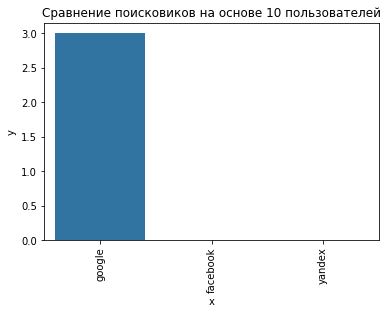

In [80]:
df = {'x': ['google','facebook','yandex'],'y': [new_features_10users['google'].median(), new_features_10users['facebook'].median(), new_features_10users['yandex'].median()]}
df = pd.DataFrame(data=df)
bp = sns.barplot(x='x',y='y',data=df)
loc, labels = plt.xticks()
bp.set_xticklabels(labels, rotation=90)
bp.set_title(u'Сравнение популярных сайтов на основе 10 пользователей')

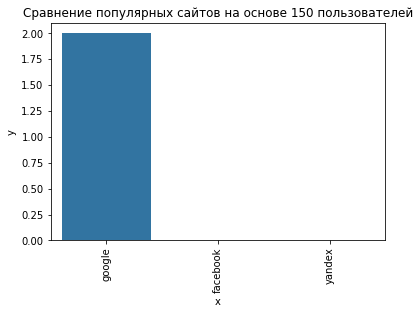

In [81]:
df = {'x': ['google','facebook','yandex'],'y': [new_features_150users['google'].median(), new_features_150users['facebook'].median(), new_features_150users['yandex'].median()]}
df = pd.DataFrame(data=df)
bp = sns.barplot(x='x',y='y',data=df)
loc, labels = plt.xticks()
bp.set_xticklabels(labels, rotation=90)
bp.set_title(u'Сравнение популярных сайтов на основе 150 пользователей')

In [82]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)
new_features_150users['target'] = new_features_150users['target'].map(id_name_dict)

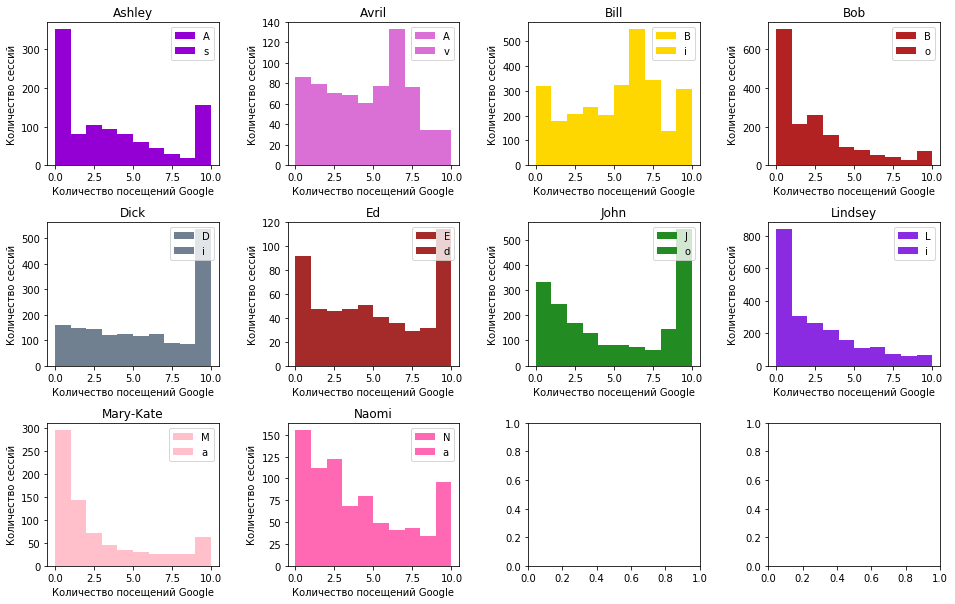

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace = 0.4,wspace = 0.4)
r,c=0,0
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    axes[r,c].hist(pd.Series(sub_df['google'].values), facecolor=color_dic[user], label=user)
    axes[r,c].set_xlabel(u'Количество посещений Google')
    axes[r,c].set_ylabel(u'Количество сессий')
    axes[r,c].set_title(user)
    axes[r,c].legend(user,loc="upper right")
    r += 1 if (r < 2) & (c == 3) else 0
    c = (c + 1) if c < 3 else 0

***Анализ новых признаков***

Из полученных графиков видно, что все пользуются Google-ом, а не Яндексом - причина - данные собраны из зарубежных источников.
Но на основе статистики использования Google все-равно можно увидеть разницу использования для наших 10 пользователей:

Ashley, Bob, Lindsey, Mary-Kate и Naomi обычно мало используют или не используют вообще Google внутри анализируемой сессии из 10 сайтов.
Dick, Ed, John сидят практически только на доменах Google.

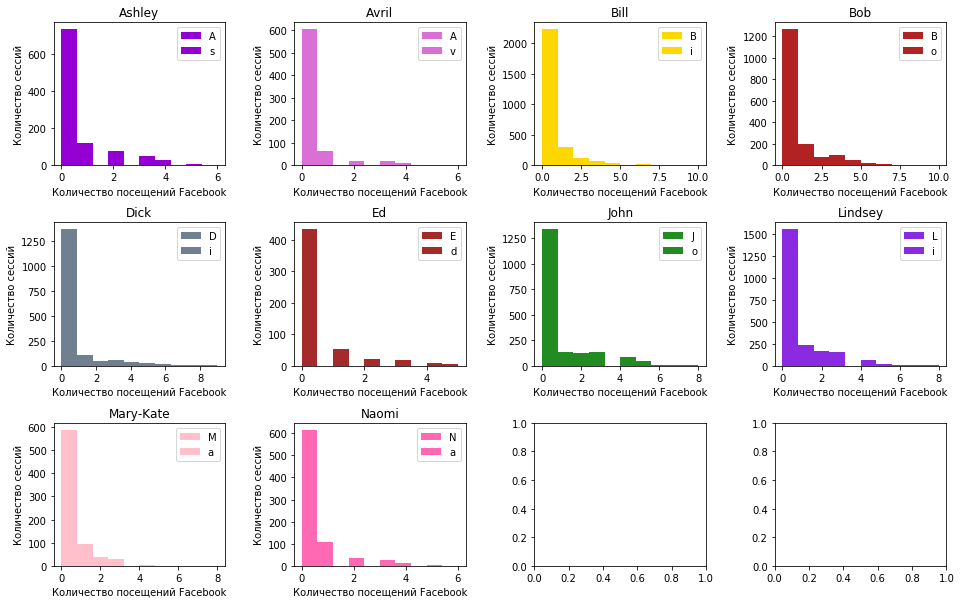

In [87]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace = 0.4,wspace = 0.4)
r,c=0,0
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    axes[r,c].hist(pd.Series(sub_df['facebook'].values), facecolor=color_dic[user], label=user)
    axes[r,c].set_xlabel(u'Количество посещений Facebook')
    axes[r,c].set_ylabel(u'Количество сессий')
    axes[r,c].set_title(user)
    axes[r,c].legend(user,loc="upper right")
    r += 1 if (r < 2) & (c == 3) else 0
    c = (c + 1) if c < 3 else 0

А здесь видно, что не особо сидит народ в фейсбуке =)

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [84]:
selected_features_10users = new_features_10users.ix[:, ['session_timespan','#unique_sites','start_hour','day_of_week','google','yandex','facebook','jobseekers']].values
selected_features_150users = new_features_150users.ix[:, ['session_timespan','#unique_sites','start_hour','day_of_week','google','yandex','facebook','jobseekers']].values

In [85]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 